<a href="https://colab.research.google.com/github/rodsei/pattern-recognition/blob/main/RENEAR_ELM_Valida%C3%A7%C3%A3o_cruzada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

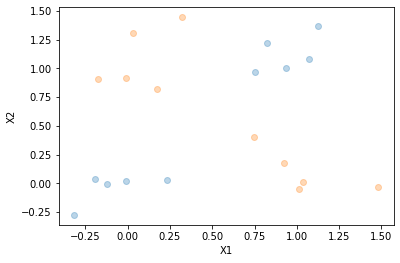

array([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0])

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import label_binarize

def geradataset(tamanho=20, centros=[[0,0],[1,0],[1,1],[0,1]]):
    X, y = make_blobs(n_samples=tamanho, centers=centros, cluster_std=0.2)
    y = np.array(y%2, dtype=int)
    return X, y

def plotadataset(X, y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

def plotahiperplano(vetor, bias=0, xmin=0, xmax=1):
    xs = np.linspace(xmin, xmax, num=2)
    ys = (-vetor[0] / vetor[1]) * xs - bias / vetor[1]
    plt.plot(xs,ys)

X, y = geradataset()
plotadataset(X, y)
plt.show()
y

In [2]:
class CustoPerceptron():
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum(CustoPerceptron.erro(y, ypred)**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, CustoPerceptron.erro(y, ypred))

class Adaline():
    def __init__(self):
        self.preactivated = True
    @staticmethod
    def erro(y, ypred):
        return y - ypred
    @staticmethod
    def custo(y, ypred):
        return np.sum((1 - Adaline.erro(y, ypred))**2)
    @staticmethod
    def gradiente(y, ypred, X):
        return np.matmul(X.T, Adaline.erro(y, ypred))

# Algoritmos

In [3]:
class DescidaGradiente():
    def __init__(self, custo=Adaline(), maxiter=1000, alpha=0.005):
        self.custo = custo
        self.maxiter = maxiter
        self.alpha = alpha
    
    def getW(self, X, y, activation=lambda a: a):
        w = np.random.uniform(-1, -1, size=(X.shape[1], y.shape[1]))
        for _ in range(self.maxiter):
            ypred = activation(np.matmul(X, w))
            custo = self.custo.custo(y, ypred)
            if custo == 0:
                break
            w = w + self.alpha * self.custo.gradiente(y, ypred, X)
        return w

class PseudoInversa():
    def __init__(self):
        pass
    def getW(self, X, y):
        pinv = np.linalg.pinv(X)
        w = np.matmul(pinv, y)
        return w

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.special import expit

def tanh(a):
    return expit(a) * 2 - 1

class ExtremeLearningMachine(BaseEstimator, ClassifierMixin):
    def __init__(self, algoritmo=PseudoInversa()):
        self.wih = None
        self.w = None
        self.threshold = 0
        self.activation = tanh
        self.algoritmo = algoritmo
    
    @staticmethod
    def includebias(X):
        bias = np.ones((X.shape[0],1))
        Xb = np.concatenate((bias,X), axis=1)
        return Xb
    
    def fit(self, X, y):
        self.wih = np.random.uniform(-1, 1, size=(X.shape[1],X.shape[0]//3))
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        X = ExtremeLearningMachine.includebias(Xho)
        self.labels = list(set(y))
        y = label_binarize(y, classes=self.labels)*2-1
        if len(self.labels) == 2 :
            y = y[:,0:1]
        # treinamento
        if hasattr(self.algoritmo, 'custo') and not (hasattr(self.algoritmo.custo, 'preactivated') and self.algoritmo.custo.preactivated):
            self.w = self.algoritmo.getW(X, y, self.activation)
        else:
            self.w = self.algoritmo.getW(X, y)

    def predict(self, X):
        Xh = np.matmul(X, self.wih)
        Xho = self.activation(Xh)
        Xb = ExtremeLearningMachine.includebias(Xho)
        a = np.matmul(Xb, self.w)
        if self.w.shape[1] > 1:
            idx = np.argmax(a, axis=1) 
        else:
            idx = np.array(self.activation(a) > self.threshold, dtype=int)[:,0]
        ypred = np.array([self.labels[i] for i in idx])
        return ypred



In [5]:
elm = ExtremeLearningMachine()
elm.fit(X, y)
ypred = elm.predict(X)
print(f"Accuracy (Training Dataset): {sum(y == ypred)/len(y)}")
# Teste com amostras fora do treinamento
Xte, yte = geradataset(5000)
ypred = elm.predict(Xte)
print(f"Accuracy (Another Dataset): {sum(yte == ypred)/len(yte)}")

Accuracy (Training Dataset): 1.0
Accuracy (Another Dataset): 0.8972


# Regiões de Decisão

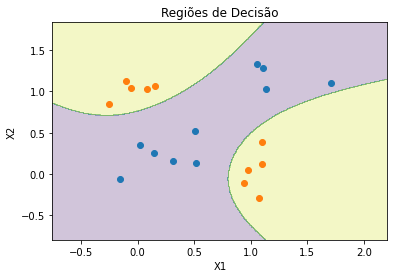

In [6]:
def plot_decision_regions(X, y, model, alpha):
  x0s = np.linspace(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, 500)
  x1s = np.linspace(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, 500)
  x0, x1 = np.meshgrid(x0s, x1s)
  X_decisions = np.c_[x0.ravel(), x1.ravel()]
  ypred = model.predict(X_decisions)
  plt.title("Regiões de Decisão")
  plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
  for k in set(y):
      plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"Cluster {k}", alpha=alpha)
  plt.xlabel("X1")
  plt.ylabel("X2")
  plt.show()

plot_decision_regions(X, y, elm, 1)

## Validando em uma base de dados real

In [96]:
from sklearn.datasets import load_digits

dataset = load_digits()
X, y = dataset.data, dataset.target
X.shape, y.shape, set(y)

((1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

In [97]:
dataset.DESCR

".. _digits_dataset:\n\nOptical recognition of handwritten digits dataset\n--------------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 5620\n    :Number of Attributes: 64\n    :Attribute Information: 8x8 image of integer pixels in the range 0..16.\n    :Missing Attribute Values: None\n    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n    :Date: July; 1998\n\nThis is a copy of the test set of the UCI ML hand-written digits datasets\nhttps://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n\nThe data set contains images of hand-written digits: 10 classes where\neach class refers to a digit.\n\nPreprocessing programs made available by NIST were used to extract\nnormalized bitmaps of handwritten digits from a preprinted form. From a\ntotal of 43 people, 30 contributed to the training set and different 13\nto the test set. 32x32 bitmaps are divided into nonoverlapping blocks of\n4x4 and the number of on pixel

In [98]:
for k in set(y):
  print(f"{k}: {sum(y == k)/len(y)*100}")

0: 9.905397885364495
1: 10.127991096271565
2: 9.84974958263773
3: 10.18363939899833
4: 10.072342793544797
5: 10.127991096271565
6: 10.072342793544797
7: 9.961046188091263
8: 9.68280467445743
9: 10.01669449081803


In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [119]:
from sklearn.model_selection import cross_validate

ndb_elm = ExtremeLearningMachine()
ndb_elm.fit(X_train, y_train)

ypred = ndb_elm.predict(X_test)

print(f"Training Accuracy: {sum(y_test == ypred)/len(y_test)}")

Training Accuracy: 0.9377777777777778


In [120]:
cv = cross_validate(ndb_elm, X_test, y_test, cv=25)

print(f"Cross Validate Average Accuracy: {cv['test_score'].mean()}")

Cross Validate Average Accuracy: 0.8466666666666666
